# Introduction
Using the Spotify API, we can scrape song data for many genres of songs. We can then train a variety of machine learning models to predict the musical genre based on the features extracted. This feature extraction has already been done in another program, producing `tracks_data.csv` where we will read in the dataframe.

# Main Objective
The main objective of this report is to analyze the song data produced by the spotify API for songs, such as "tempo", "danceability", "energy", "acousticness", "duration", and more to attempt and accurately classify the musical genre. 

This can identify leading trends within different genres, as well as unexpected connections and room for business development between different genres, leading to musical artist success. Particularly, the information presented here is useful for allowing an individual to predict the genre of their own music in accord with the Spotify API's data extraction.

# Data set selection
I created a Flask application to scrape data from various genre playlists found within Spotify's databases, using my personal Spotify API key. The general format of this data scraper I made is below:

In [ ]:
from flask import Flask, redirect, request, session, jsonify, url_for
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
import pandas as pd
import time
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

app = Flask(__name__)
app.secret_key = os.urandom(24)
app.config['SESSION_COOKIE_NAME'] = 'spotify-login-session'

SPOTIPY_CLIENT_ID = 'PUT YOUR SPOTIFY CLIENT ID HERE'
SPOTIPY_CLIENT_SECRET = 'PUT YOUR SPOTIFY CLIENT SCRET HERE'
SPOTIPY_REDIRECT_URI = 'http://localhost:8888/callback'

os.environ['SPOTIPY_CLIENT_ID'] = SPOTIPY_CLIENT_ID
os.environ['SPOTIPY_CLIENT_SECRET'] = SPOTIPY_CLIENT_SECRET
os.environ['SPOTIPY_REDIRECT_URI'] = SPOTIPY_REDIRECT_URI

sp_oauth = SpotifyOAuth(scope="playlist-read-private user-library-read")

def get_audio_features_with_retries(sp, track_id, max_retries=10, base_sleep_time=1):
    retries = 0
    while retries < max_retries:
        try:
            audio_features = sp.audio_features(track_id)[0]
            return audio_features
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', base_sleep_time * (2 ** retries)))
                logger.warning(f"Rate limited. Retrying in {retry_after} seconds... (Retry {retries + 1}/{max_retries})")
                time.sleep(retry_after)
                retries += 1
            else:
                logger.error(f"Failed to fetch audio features for track ID {track_id}: {e}")
                break
    logger.error(f"Max retries exceeded for track ID {track_id}")
    return None

@app.route('/')
def login():
    auth_url = sp_oauth.get_authorize_url()
    return redirect(auth_url)

@app.route('/callback')
def callback():
    session.clear()
    code = request.args.get('code')
    token_info = sp_oauth.get_access_token(code)
    session['token_info'] = token_info
    return redirect('/getTopTracks')

@app.route('/getTopTracks')
def get_track():
    token_info = session.get('token_info', None)
    if not token_info:
        return redirect('/')
    
    sp = spotipy.Spotify(auth=token_info['access_token'])
    genre_playlists = {
        'pop': '1WH6WVBwPBz35ZbWsgCpgr',
        'rock': '7DgPQwzEoUVfQYBiMLER9Z',
        'hip-hop': '02okEcUQXHe2sS5ajE9XG0',
        'country': '2Hi4RV1DJHHiSDcwYFFKeR',
        'metal': '1yMlpNGEpIVUIilZlrbdS0',
        'classical': '2AIyLES2xJfPa6EOxmKySl',
        'jazz': '6ylvGA8NeX2CuaeGtwHWDJ',
        'electronic': '2e3dcRuo9uDH6qD3NOGKAL',
        'rap': '041EEjr8FMkWlzbuKnSXYD'
    }
    
    tracks_data = []
    for genre, playlist_id in genre_playlists.items():
        playlist_tracks = sp.playlist_tracks(playlist_id, limit=100)
        
        for item in playlist_tracks['items']:
            track = item['track']
            track_id = track['id']
            track_name = track['name']
            artist_name = track['artists'][0]['name']
            
            # Get audio features with retries
            audio_features = get_audio_features_with_retries(sp, track_id)
            if not audio_features:
                logger.error(f"Skipping track ID {track_id} due to errors")
                continue
            
            track_data = {
                'genre': genre,
                'track_id': track_id,
                'track_name': track_name,
                'artist_name': artist_name,
                'tempo': audio_features['tempo'],
                'danceability': audio_features['danceability'],
                'energy': audio_features['energy'],
                'acousticness': audio_features['acousticness'],
                'duration_ms': audio_features['duration_ms'],
                'instrumentalness': audio_features['instrumentalness'],
                'liveness': audio_features['liveness'],
                'loudness': audio_features['loudness'],
                'mode': audio_features['mode'],
                'speechiness': audio_features['speechiness'],
                'time_signature': audio_features['time_signature'],
                'valence': audio_features['valence']
            }
            tracks_data.append(track_data)
            # Add a delay between requests to manage rate limit
            time.sleep(1)  # Sleep for 1 second between requests
    
    df = pd.DataFrame(tracks_data)
    df.to_csv('tracks_data.csv', index=False)
    
    return jsonify(tracks_data)

if __name__ == '__main__':
    app.run(port=8888)


With the features in the `track_data` dictionary above, we chose up to 100 songs of each genre listed in the dictionary `genre_playlists`, which links straight to the Spotify ID of those curated playlists. This is in an effort to **balance** the data sets from the beginning. 

The scraped data is then put into a `tracks_data.csv` file, allowing us to read it into Pandas.

# Audio features extracted from Spotify API
This information is pulled from https://developer.spotify.com/documentation/web-api/reference/get-audio-features

| Feature | Data type | Description |
| ------- | --------- | ----------- |
| acousticness | number [float] | A confidence measure from 0.0 to 1.0 of whether the track si acoustic, with 1 being high confidence |
| danceability | number [float] | Describes how suitable a track is for dancing based on a combo of musical elements including tempo, rhythm stability, beat strength, and overall regularity. |
| duration_ms | integer | Duration of the track in milliseconds. |
| energy | number [float] | A measure from 0.0 to 1.0 representing a perceptual measure of intensity and activity. |
| id | string | Spotify ID for the track |
| instrumentalness | number [float] | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental. |
| key | integer | Key the track is in, mapping integers to pitches using standard Pitch Class notation. |
| liveness | number [float] | Detects presence of an audience in recording. |
| loudness | number [float] | Overall loudness of a track in decibels (dB), averaged across entire track. |
| mode | integer | Indicates modality (major or minor) of a track, the type of scale from which melodic content is derived. Major = 1, minor = 0. |
| speechiness | number [float] | Detects presence of spoken words in a track. |
| tempo | number [float] | Overall estimated tempo of a track in beats per minute (BPM). |
| time_signature | integer | Estimated time signature, between 3 (3/4) and 7 (7/4). |
| valence | number [float] | Describes musical positiveness conveyed by a track. |

# Primary goals
We want to see if it is possible to accurately predict the genre of a piece of music, given various features of its musicality, such as "liveness", "instrumentalness", "energy", and many more features calculated by the Spotify API. In future versions of this project, we can add in signal analysis of the audio files themselves, permitting an even more specialized and nuanced understanding of the audio structure of different genres.

# Data Exploration:
In the Spotify API scraper above, we made sure that if there were errors or NANs in the song data values. As shown in the table above, most relevant features to the classification were numerical, so label encoding was unnecessary, except to enumerate different genres being predicted.

In [13]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('tracks_data.csv')

# Display the first few rows of the dataframe
df.head()

,genre,track_id,track_name,artist_name,tempo,danceability,energy,acousticness,duration_ms,instrumentalness,liveness,loudness,mode,speechiness,time_signature,valence
0,pop,3Dv1eDb0MEgF93GpLXlucZ,Say So,Doja Cat,110.962,0.787,0.673,0.2640,237893,0.000003,0.0904,-4.583,0,0.159,4,0.779
1,pop,7MXVkk9YMctZqd1Srtv4MB,Starboy,The Weeknd,186.003,0.679,0.587,0.1410,230453,0.000006,0.1370,-7.015,1,0.276,4,0.486
2,pop,0t3ZvGKlmYmVsDzBJAXK8C,Goodbyes (feat. Young Thug),Post Malone,150.097,0.547,0.653,0.4560,174853,0.000000,0.1030,-3.875,1,0.081,4,0.163
3,pop,7ytR5pFWmSjzHJIeQkgog4,ROCKSTAR (feat. Roddy Ricch),DaBaby,89.977,0.746,0.690,0.2470,181733,0.000000,0.1010,-7.956,1,0.164,4,0.497
4,pop,6DCZcSspjsKoFjzjrWoCdn,God's Plan,Drake,77.169,0.754,0.449,0.0332,198973,0.000083,0.5520,-9.211,1,0.109,4,0.357


Some songs may be cross-genre, so we want to remove duplicates that would cause the predictor to have two valid outcomes. We want unique outcomes. We can also shuffle the data to avoid clumping of a single genre as we progress randomly through the table to sample.

## Analyzing Covariance of Data


We need to clean the data some first and remove duplicates and isolate the unique genre names.

In [32]:

# Check for duplicates and remove them
df = df.drop_duplicates(subset='track_id')

# Shuffle the data
df = df.sample(frac=1, random_state=420).reset_index(drop=True)

# Capture the unique genre labels before encoding
genre_labels = df['genre'].unique()

# Encode the genre as numerical values
df['genre'] = df['genre'].astype('category').cat.codes

# Separate features and target variable
X = df.drop(columns=['genre', 'track_id', 'track_name', 'artist_name'])
y = df['genre']

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

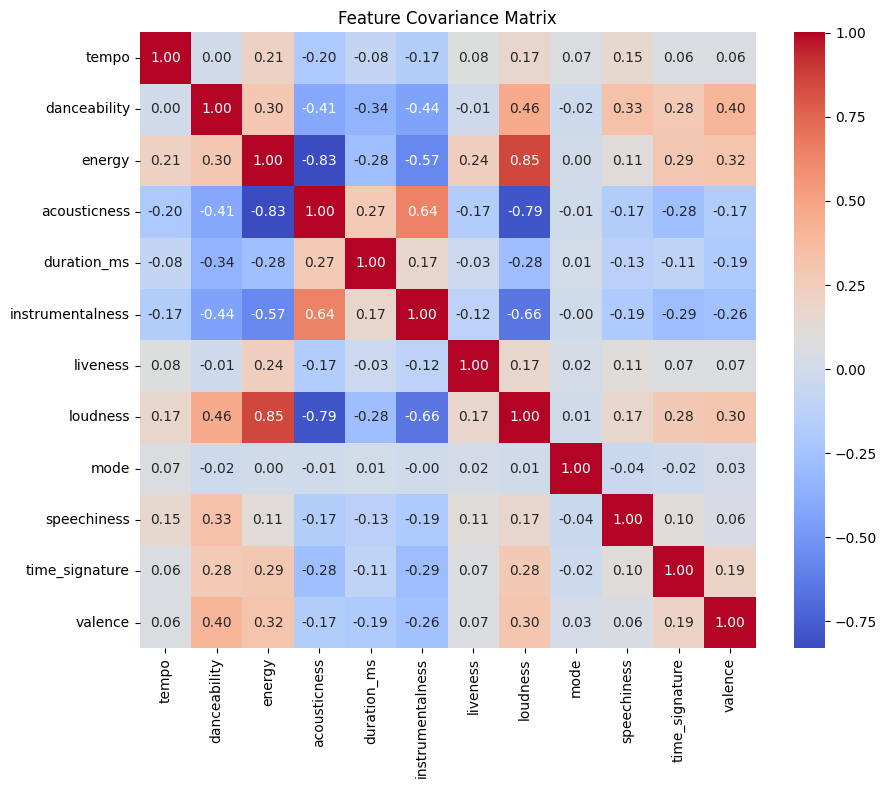

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate covariance matrix
covariance_matrix = X_scaled_df.cov()

# Plot the covariance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Covariance Matrix")
plt.show()


Clearly, there are some correlations, like positive connections between energy and loudness, or strong negative correlations between acousticness and loudness, both of which make sense from an audio perspective.

In [15]:
# Split the data as needed
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=420)

# ML Models

## Logistic Regression

Best parameters for Logistic Regression: {'C': 1000, 'solver': 'lbfgs'}
Best score for Logistic Regression: 0.6391304347826086
Logistic Regression Accuracy: 0.6069364161849711
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.67      0.75      0.71        16
           2       0.58      0.79      0.67        14
           3       0.38      0.33      0.35        18
           4       0.86      0.75      0.80        24
           5       0.60      0.47      0.53        19
           6       0.54      0.65      0.59        20
           7       0.47      0.30      0.37        23
           8       0.52      0.61      0.56        18

    accuracy                           0.61       173
   macro avg       0.60      0.61      0.60       173
weighted avg       0.60      0.61      0.60       173



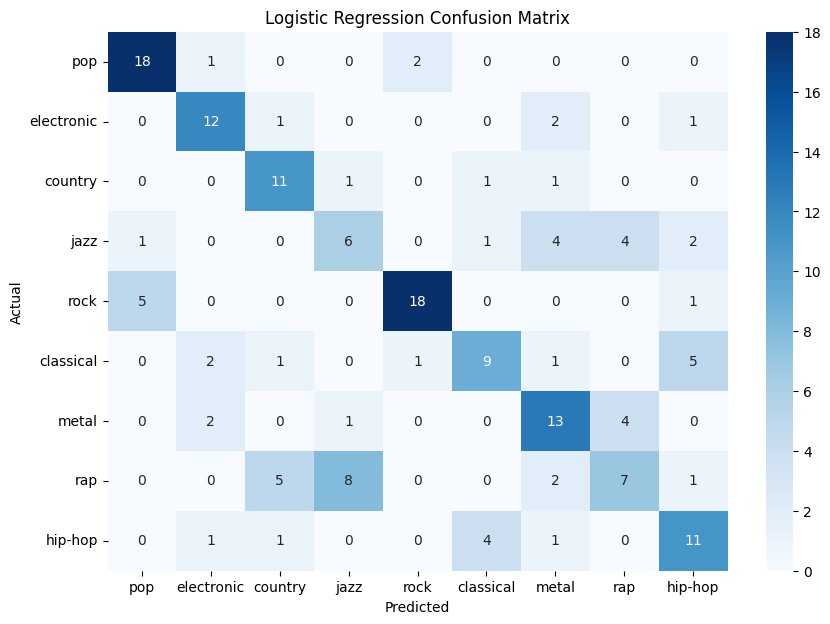

In [16]:
# Create a GridSearchCV parameter library to optimize
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'lbfgs']
}

# Create the GridSearchCV object
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy')
# Fit this model
grid_search_lr.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
lr_best_model = grid_search_lr.best_estimator_
print("Best score for Logistic Regression:", grid_search_lr.best_score_)
lrScore = grid_search_lr.best_score_
y_pred_lr = grid_search_lr.best_estimator_.predict(X_test)
lrAccuracy = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Random Forest

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 500}
Best score for Random Forest: 0.673913043478261
Random Forest Accuracy: 0.6069364161849711
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.68      0.81      0.74        16
           2       0.59      0.71      0.65        14
           3       0.33      0.39      0.36        18
           4       0.73      0.79      0.76        24
           5       0.75      0.47      0.58        19
           6       0.61      0.55      0.58        20
           7       0.38      0.22      0.28        23
           8       0.52      0.67      0.59        18

    accuracy                           0.61       173
   macro avg       0.60      0.61      0.60       173
weighted avg       0.60      0.61      0.59       173



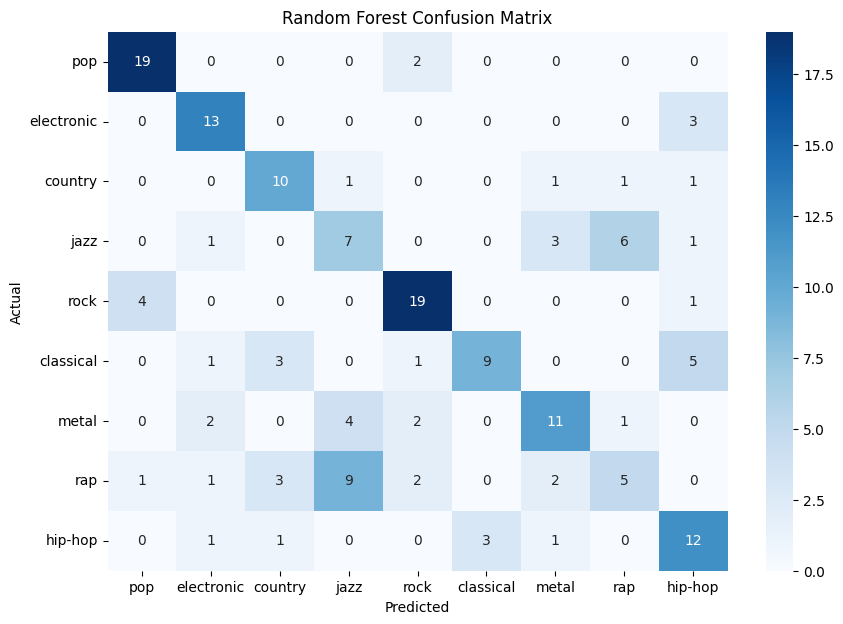

In [17]:
param_grid_rf = {
    'n_estimators': [25, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV object
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
# Fit
grid_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
rf_best_model = grid_search_rf.best_estimator_
print("Best score for Random Forest:", grid_search_rf.best_score_)
rfScore = grid_search_rf.best_score_
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
rfAccuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Support Vector Machine (SVM)

Best parameters for SVM: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best score for SVM: 0.6405797101449275
Random Forest Accuracy: 0.5953757225433526
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.79      0.69      0.73        16
           2       0.56      0.71      0.62        14
           3       0.31      0.28      0.29        18
           4       0.77      0.83      0.80        24
           5       0.58      0.37      0.45        19
           6       0.46      0.65      0.54        20
           7       0.47      0.30      0.37        23
           8       0.57      0.72      0.63        18

    accuracy                           0.60       173
   macro avg       0.59      0.60      0.58       173
weighted avg       0.59      0.60      0.59       173



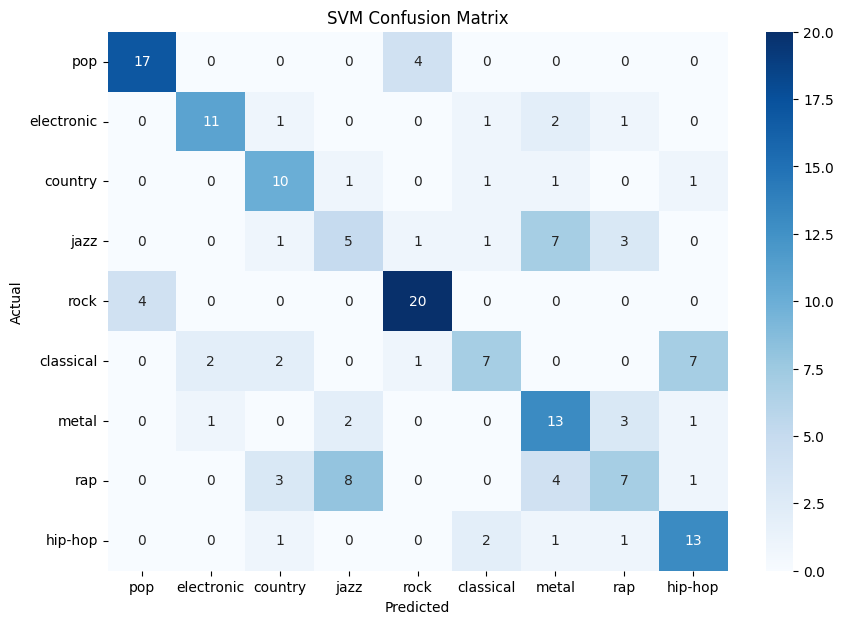

In [18]:
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# GridSearchCV object
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
# Fit
grid_search_svm.fit(X_train, y_train)

print("Best parameters for SVM:", grid_search_svm.best_params_)
svm_best_model = grid_search_svm.best_estimator_
print("Best score for SVM:", grid_search_svm.best_score_)
svmScore = grid_search_svm.best_score_
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test)
svmAccuracy = accuracy_score(y_test, y_pred_svm)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Decision Tree

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Best score for Decision Tree: 0.5463768115942029
Decision Tree Accuracy: 0.4913294797687861
              precision    recall  f1-score   support

           0       0.68      0.71      0.70        21
           1       0.56      0.56      0.56        16
           2       0.45      0.71      0.56        14
           3       0.30      0.33      0.32        18
           4       0.65      0.62      0.64        24
           5       0.50      0.42      0.46        19
           6       0.45      0.45      0.45        20
           7       0.36      0.17      0.24        23
           8       0.39      0.50      0.44        18

    accuracy                           0.49       173
   macro avg       0.48      0.50      0.48       173
weighted avg       0.49      0.49      0.48       173



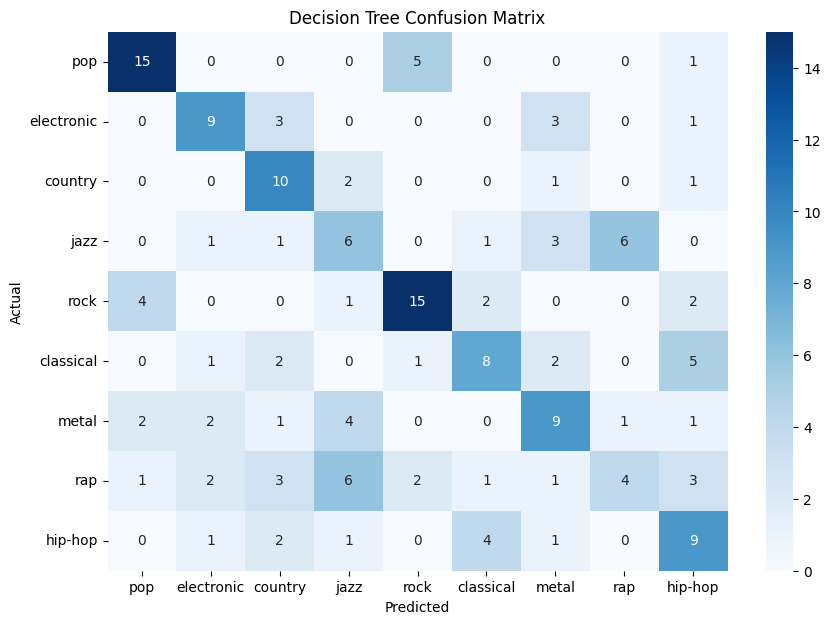

In [19]:
# Define the parameter grid
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 10, 20]
}

# Create a GridSearchCV object
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy')

# Fit the model
grid_search_dt.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
dt_best_model = grid_search_dt.best_estimator_
print("Best score for Decision Tree:", grid_search_dt.best_score_)
dtScore = grid_search_dt.best_score_
# Predict on the test set
y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)
dtAccuracy = accuracy_score(y_test, y_pred_dt)
# Evaluate the model
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## K-Nearest Neighbors (KNN)

Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best score for KNN: 0.5739130434782609
KNN Accuracy: 0.5664739884393064
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.42      0.81      0.55        16
           2       0.71      0.71      0.71        14
           3       0.35      0.33      0.34        18
           4       0.84      0.67      0.74        24
           5       0.56      0.47      0.51        19
           6       0.50      0.55      0.52        20
           7       0.67      0.26      0.38        23
           8       0.39      0.50      0.44        18

    accuracy                           0.57       173
   macro avg       0.59      0.57      0.56       173
weighted avg       0.60      0.57      0.56       173



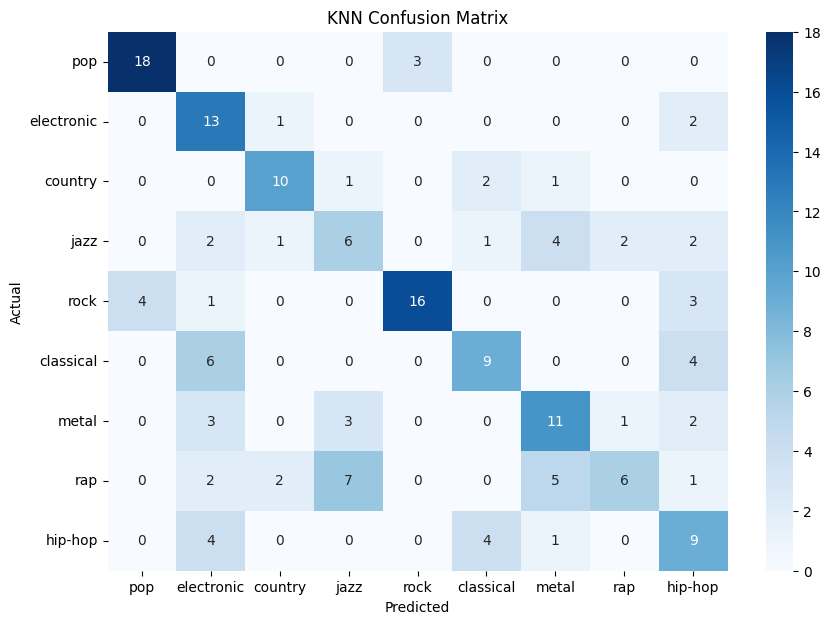

In [20]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create a GridSearchCV object
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')

# Fit the model
grid_search_knn.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for KNN:", grid_search_knn.best_params_)
knn_best_model = grid_search_knn.best_estimator_
print("Best score for KNN:", grid_search_knn.best_score_)

# Predict on the test set
y_pred_knn = grid_search_knn.best_estimator_.predict(X_test)

# Evaluate the model
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Ensemble Methods
Let's see if ensemble methods can afford us a bit better recall, precision, and other scores!

In [21]:
# Importing ensemble libraries
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

## Gradient Boosting

In [23]:
# Gradient boosting parameter grid for CV
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
# GridSearchCV with 5 folds
gb_grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state = 420),
                       param_grid=gb_param_grid, cv=5, scoring='accuracy')
# Fit training data
gb_grid.fit(X_train, y_train)
print("Best parameters for Gradient Boosting:", gb_grid.best_params_)
gb_best_model = gb_grid.best_estimator_
# Get best predictions
gb_predictions = gb_best_model.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_predictions))
print(classification_report(y_test, gb_predictions))

Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Gradient Boosting Accuracy: 0.5780346820809249
              precision    recall  f1-score   support

           0       0.73      0.76      0.74        21
           1       0.75      0.75      0.75        16
           2       0.73      0.79      0.76        14
           3       0.33      0.28      0.30        18
           4       0.69      0.75      0.72        24
           5       0.73      0.42      0.53        19
           6       0.42      0.50      0.45        20
           7       0.38      0.35      0.36        23
           8       0.52      0.67      0.59        18

    accuracy                           0.58       173
   macro avg       0.59      0.58      0.58       173
weighted avg       0.58      0.58      0.57       173



## AdaBoost

In [24]:
# Adaptive Boosting parameter grid for CV
ada_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.5, 1.25]
}
# GridSearchCV with 5 folds
ada_grid = GridSearchCV(estimator=AdaBoostClassifier(random_state=420),
                        param_grid=ada_param_grid, cv=5, scoring='accuracy')
# Fit training data
ada_grid.fit(X_train, y_train)
print("Best parameters for AdaBoost:", ada_grid.best_params_)
ada_best_model = ada_grid.best_estimator_
# Get best predictions
ada_predictions = ada_best_model.predict(X_test)
print("AdaBoosting Accuracy:", accuracy_score(y_test, ada_predictions))
print(classification_report(y_test, ada_predictions))

Best parameters for AdaBoost: {'learning_rate': 0.5, 'n_estimators': 50}
AdaBoosting Accuracy: 0.44508670520231214
              precision    recall  f1-score   support

           0       0.77      0.48      0.59        21
           1       0.48      0.81      0.60        16
           2       0.50      0.50      0.50        14
           3       0.29      0.11      0.16        18
           4       0.64      0.58      0.61        24
           5       0.80      0.21      0.33        19
           6       0.29      0.55      0.38        20
           7       0.35      0.30      0.33        23
           8       0.33      0.50      0.40        18

    accuracy                           0.45       173
   macro avg       0.49      0.45      0.43       173
weighted avg       0.50      0.45      0.43       173



## Voting Classifier with Best Models
We have tuned individual models, so let's use the best models in a voting classifier for the final predictions.

In [25]:
# Define parameter grid for another GridSearchCV
voting_param_grid = {
    'voting': ['hard', 'soft']
}
# Set up GridSearchCV
voting_model = VotingClassifier(
    estimators=[('rf', rf_best_model), ('gb', gb_best_model), ('ada', ada_best_model),
                ('knn', knn_best_model), ('lr', lr_best_model), ('svm', svm_best_model),
                ('dt', dt_best_model)]
)
voting_grid = GridSearchCV(estimator=voting_model, param_grid=voting_param_grid, cv=5, scoring='accuracy')
# Fit training data
voting_grid.fit(X_train, y_train)
print("Best parameters for voting classifier:", voting_grid.best_params_)
voting_best_model = voting_grid.best_estimator_
# Get best predictions
voting_predictions = voting_best_model.predict(X_test)
print("Voting classifier accuracy:", accuracy_score(y_test, voting_predictions))
print(classification_report(y_test, voting_predictions))

Best parameters for voting classifier: {'voting': 'hard'}
Voting classifier accuracy: 0.6127167630057804
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        21
           1       0.70      0.88      0.78        16
           2       0.60      0.86      0.71        14
           3       0.35      0.39      0.37        18
           4       0.79      0.79      0.79        24
           5       0.69      0.47      0.56        19
           6       0.55      0.55      0.55        20
           7       0.36      0.22      0.27        23
           8       0.58      0.61      0.59        18

    accuracy                           0.61       173
   macro avg       0.60      0.62      0.60       173
weighted avg       0.60      0.61      0.60       173



# Visualizing results
Here we can compare all of the single-model ML results with these ensemble methods, across various evaluation metrics. In summary, **Decision Trees** performed the poorest, whereas **Random Forests** performed the best, which makes sense due to their relative complexities. 

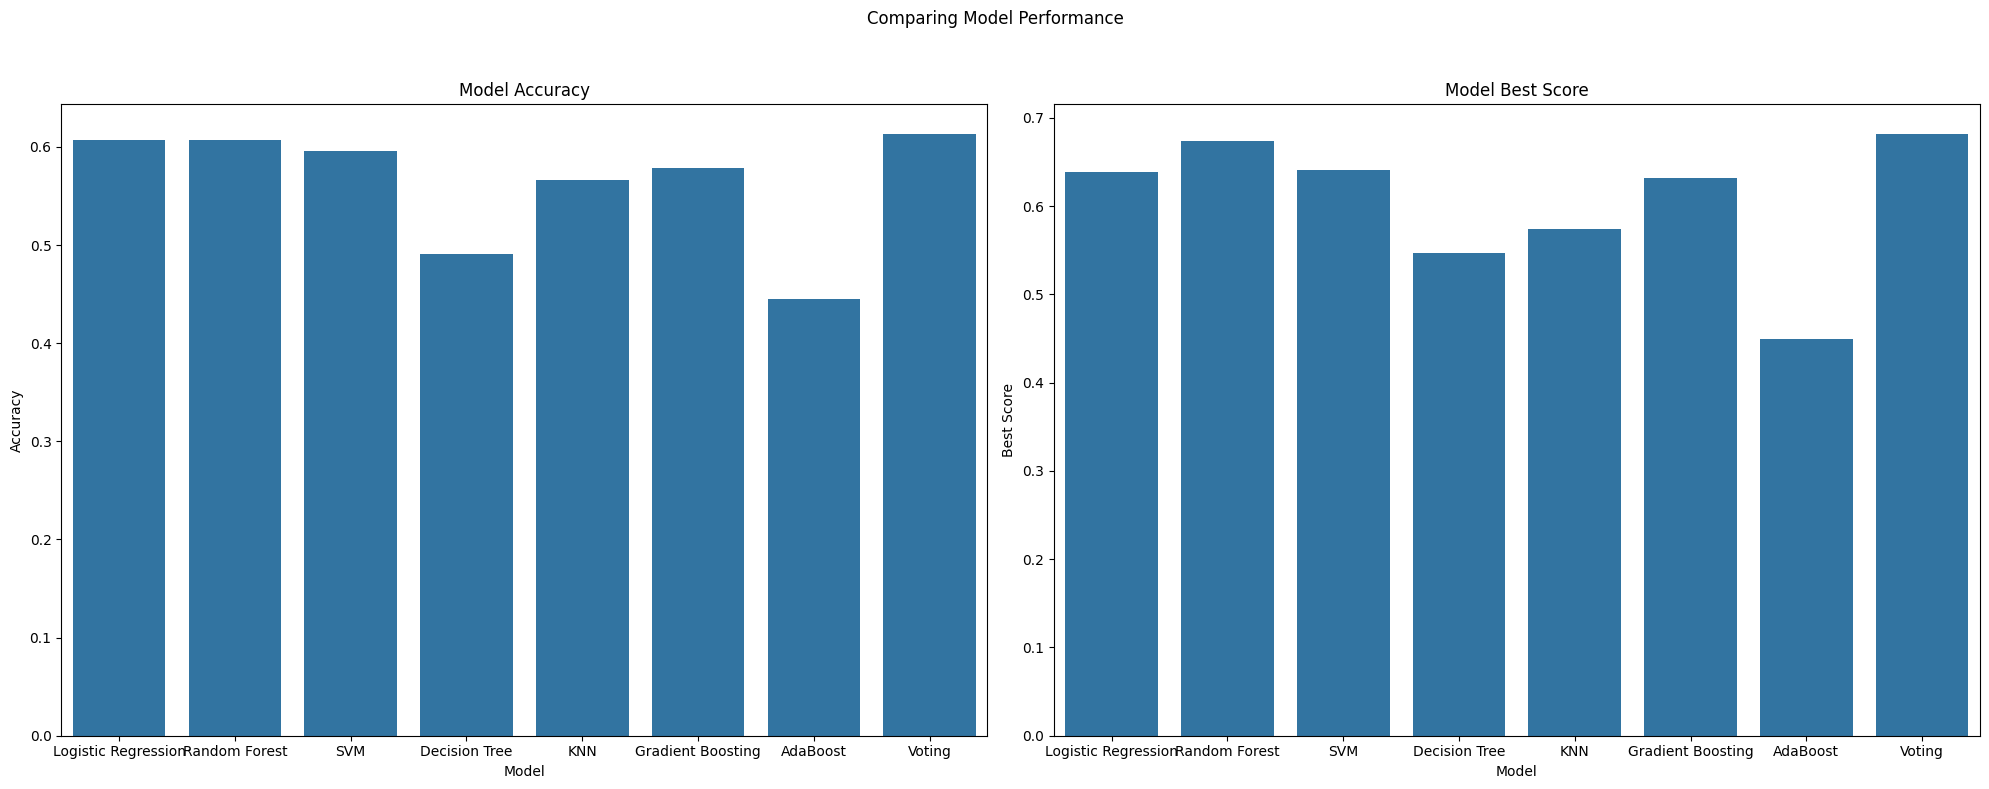

In [26]:
accuracyResults = {
    'Logistic Regression': lrAccuracy,
    'Random Forest': rfAccuracy,
    'SVM': svmAccuracy,
    'Decision Tree': dtAccuracy,
    'KNN': accuracy_score(y_test, y_pred_knn),
    'Gradient Boosting': accuracy_score(y_test, gb_predictions),
    'AdaBoost': accuracy_score(y_test, ada_predictions),
    'Voting': accuracy_score(y_test, voting_predictions)
}
scoreResults = {
    'Logistic Regression': lrScore,
    'Random Forest': rfScore,
    'SVM': svmScore,
    'Decision Tree': dtScore,
    'KNN': grid_search_knn.best_score_,
    'Gradient Boosting': gb_grid.best_score_,
    'AdaBoost': ada_grid.best_score_,
    'Voting': voting_grid.best_score_
}
accuracyResults_df = pd.DataFrame.from_dict(accuracyResults, orient='index', columns=['Accuracy'])
scoreResults_df = pd.DataFrame.from_dict(scoreResults, orient='index', columns=['Score'])
accuracyResults_df.sort_values(by='Accuracy', ascending=False)
scoreResults_df.sort_values(by='Score', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x=accuracyResults_df.index, y='Accuracy', data=accuracyResults_df, ax=axes[0])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Model')

sns.barplot(x=scoreResults_df.index, y='Score', data=scoreResults_df, ax=axes[1])
axes[1].set_title('Model Best Score')
axes[1].set_ylabel('Best Score')
axes[1].set_xlabel('Model')

fig.suptitle('Comparing Model Performance')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# Summary Key Findings and Insights
For single-model ML techniques, we found that Random Forests performed with cross-validation generally performed the best based on the F1 score and many other metrics. The confusion matrix above also demonstrated the least amount of confusion for this type of model, where as a decision tree (arguably a single instance within a random forest) proved to score the least, which is understandable. Interestingly, many of these models found correlations between the predicted genres, as shown in the confusion matrices. The extent of this confusion differed by model too. For example, Decision Tree model had a strong confusion in predicting rap as jazz, and many of the others found an interesting correlation here, too, but to a lesser degree.

For ensemble-based methods, of course voting with the best of each of these models trained and developed produced the best results over-all, so the best solution I would provide the client would be this voting model that captures the best features and predictions of each individual machine learning model. 

It is my hypothesis that further features from the audio signals themselves, or PCA on those audio features produced by doing signal analysis, can provide the models with the key features needed to differentiate genres more effectively.

# Final Recommended Model
I recommend that the voting model is used, which integrates the best results from each other model trained here.

# Suggestions for Next Steps
- Incorporate more advanced and complex models, including neural networks (see below for an example)
- Enhance data by doing actual audio/signal analysis on each individual songs, outside of what Spotify API provides.
    - These can be accelerated via GPU computation, see my GitHub for example.
- Explore commonalities between genres and expand the scope of the GridSearchCV dictionaries above to identify more finetuning opportunities of hyperparameters. 

# Extra: neural network using TensorFlow

In [27]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

df = pd.read_csv('tracks_data.csv')
print(df.head())

X = df.drop(columns=['genre', 'track_id', 'track_name', 'artist_name'])
y = df['genre']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size = 0.2, random_state = 42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

  genre                track_id                    track_name  artist_name  \
0   pop  3Dv1eDb0MEgF93GpLXlucZ                        Say So     Doja Cat   
1   pop  7MXVkk9YMctZqd1Srtv4MB                       Starboy   The Weeknd   
2   pop  0t3ZvGKlmYmVsDzBJAXK8C   Goodbyes (feat. Young Thug)  Post Malone   
3   pop  7ytR5pFWmSjzHJIeQkgog4  ROCKSTAR (feat. Roddy Ricch)       DaBaby   
4   pop  6DCZcSspjsKoFjzjrWoCdn                    God's Plan        Drake   

     tempo  danceability  energy  acousticness  duration_ms  instrumentalness  \
0  110.962         0.787   0.673        0.2640       237893          0.000003   
1  186.003         0.679   0.587        0.1410       230453          0.000006   
2  150.097         0.547   0.653        0.4560       174853          0.000000   
3   89.977         0.746   0.690        0.2470       181733          0.000000   
4   77.169         0.754   0.449        0.0332       198973          0.000083   

   liveness  loudness  mode  speechiness  ti

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,585 (49.16 KB)

 Trainable params: 12,585 (49.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=500, batch_size=50, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

Test accuracy: 0.6444


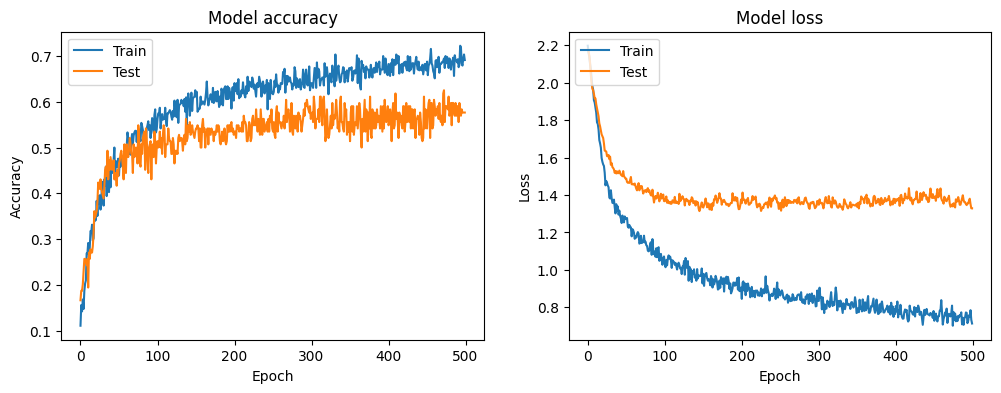

In [30]:
print(f'Test accuracy: {test_accuracy:.4f}')
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [29]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

   classical       1.00      0.91      0.95        23
     country       0.68      0.77      0.72        22
  electronic       0.82      0.78      0.80        18
     hip-hop       0.64      0.32      0.42        22
        jazz       0.88      0.94      0.91        16
       metal       0.65      0.50      0.56        22
         pop       0.54      0.52      0.53        25
         rap       0.48      0.68      0.57        19
        rock       0.24      0.38      0.29        13

    accuracy                           0.64       180
   macro avg       0.66      0.65      0.64       180
weighted avg       0.67      0.64      0.65       180



# Clearly, there is a need for significantly more data on the audio features themselves, coming from signal analysis.